## Dependencies

In [52]:
import transformer_lens
from transformer_lens import HookedTransformer, utils
import torch
import numpy as np
import gradio as gr
import pprint
import json
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from huggingface_hub import HfApi
from IPython.display import HTML
from functools import partial
import tqdm.notebook as tqdm
import plotly.express as px
import pandas as pd

## Defining the Autoencoder

In [127]:
cfg = {
    "seed": 49,
    "batch_size": 4096,
    "buffer_mult": 384,
    "lr": 1e-4,
    "num_tokens": int(2e9),
    "l1_coeff": 3e-4,
    "beta1": 0.9,
    "beta2": 0.99,
    "dict_mult": 8,
    "seq_len": 128,
    "d_mlp": 2048,
    "enc_dtype":"fp32",
    "remove_rare_dir": False,
}
cfg["model_batch_size"] = 64
cfg["buffer_size"] = cfg["batch_size"] * cfg["buffer_mult"]
cfg["buffer_batches"] = cfg["buffer_size"] // cfg["seq_len"]

In [157]:
DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}
neuron_to_ablate= False
class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        d_hidden = cfg["d_mlp"] * cfg["dict_mult"]
        d_mlp = cfg["d_mlp"]
        l1_coeff = cfg["l1_coeff"]
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])
        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_mlp, d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, d_mlp, dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(d_mlp, dtype=dtype))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff

        # self.to("cuda")

    def forward(self, x):
        global neuron_to_ablate
        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        # if neuron_to_ablate:
        #     print(f"ablating {neuron_to_ablate}")
        #     if not (acts[:,:,neuron_to_ablate] == 0).any():
        #         raise Exception("Feature is not activated")
        #     acts[:,:,neuron_to_ablate] = 0 
        #     neuron_to_ablate = False
        x_reconstruct = acts @ self.W_dec + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss

    @torch.no_grad()
    def remove_parallel_component_of_grads(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj

    @classmethod
    def load_from_hf(cls, version):
        """
        Loads the saved autoencoder from HuggingFace.

        Version is expected to be an int, or "run1" or "run2"

        version 25 is the final checkpoint of the first autoencoder run,
        version 47 is the final checkpoint of the second autoencoder run.
        """
        if version=="run1":
            version = 25
        elif version=="run2":
            version = 47

        cfg = utils.download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version}_cfg.json")
        pprint.pprint(cfg)
        self = cls(cfg=cfg)
        self.load_state_dict(utils.download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version}.pt", force_is_torch=True))
        return self


## Utils

### Get Reconstruction Loss

In [55]:
def replacement_hook(mlp_post, hook, encoder):
    mlp_post_reconstr = encoder(mlp_post)[1]
    return mlp_post_reconstr

def mean_ablate_hook(mlp_post, hook):
    mlp_post[:] = mlp_post.mean([0, 1])
    return mlp_post

def zero_ablate_hook(mlp_post, hook):
    mlp_post[:] = 0.
    return mlp_post

@torch.no_grad()
def get_recons_loss(num_batches=5, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    loss_list = []
    for i in range(num_batches):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]]
        loss = model(tokens, return_type="loss")
        recons_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(utils.get_act_name("post", 0), partial(replacement_hook, encoder=local_encoder))])
        # mean_abl_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(utils.get_act_name("post", 0), mean_ablate_hook)])
        zero_abl_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(utils.get_act_name("post", 0), zero_ablate_hook)])
        loss_list.append((loss, recons_loss, zero_abl_loss))
    losses = torch.tensor(loss_list)
    loss, recons_loss, zero_abl_loss = losses.mean(0).tolist()

    print(f"loss: {loss:.4f}, recons_loss: {recons_loss:.4f}, zero_abl_loss: {zero_abl_loss:.4f}")
    score = ((zero_abl_loss - recons_loss)/(zero_abl_loss - loss))
    print(f"Reconstruction Score: {score:.2%}")
    # print(f"{((zero_abl_loss - mean_abl_loss)/(zero_abl_loss - loss)).item():.2%}")
    return score, loss, recons_loss, zero_abl_loss

### Get Frequencies

In [56]:
# Frequency
@torch.no_grad()
def get_freqs(num_batches=25, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    act_freq_scores = torch.zeros(local_encoder.d_hidden, dtype=torch.float32)
    total = 0
    for i in tqdm.trange(num_batches):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]]

        _, cache = model.run_with_cache(tokens, stop_at_layer=1)
        mlp_acts = cache[utils.get_act_name("post", 0)]
        mlp_acts = mlp_acts.reshape(-1, d_mlp)

        hidden = local_encoder(mlp_acts)[2]

        act_freq_scores += (hidden > 0).sum(0)
        total+=hidden.shape[0]
    act_freq_scores /= total
    num_dead = (act_freq_scores==0).float().mean()
    print("Num dead", num_dead)
    return act_freq_scores

## Loading the Model

In [158]:
model = HookedTransformer.from_pretrained("gelu-1l").to(DTYPES[cfg["enc_dtype"]])
n_layers = model.cfg.n_layers
d_model = model.cfg.d_model
n_heads = model.cfg.n_heads
d_head = model.cfg.d_head
d_mlp = model.cfg.d_mlp
d_vocab = model.cfg.d_vocab

Loaded pretrained model gelu-1l into HookedTransformer
Changing model dtype to torch.float32


## Loading Data

In [59]:
data = load_dataset("NeelNanda/c4-code-20k", split="train")
tokenized_data = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=128)
#tokenized_data = tokenized_data.shuffle(42)
all_tokens = tokenized_data["tokens"]



Found cached dataset parquet (/Users/pavan/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--c4-code-20k-b5c495283d11e5f6/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /Users/pavan/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--c4-code-20k-b5c495283d11e5f6/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-3cf65656d0cacb28_*_of_00010.arrow


# Analysis

## Loading the Autoencoder

There are two runs on separate random seeds, along with a bunch of intermediate checkpoints

In [159]:
auto_encoder_run = "run1" # @param ["run1", "run2"]
encoder = AutoEncoder.load_from_hf(auto_encoder_run)

{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 2048,
 'dict_mult': 8,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'lr': 0.0001,
 'model_batch_size': 512,
 'num_tokens': 2000000000,
 'seed': 52,
 'seq_len': 128}


## Using the Autoencoder

We run the model and replace the MLP activations with those reconstructed from the autoencoder, and get 91% loss recovered

In [140]:
_ = get_recons_loss(num_batches=5, local_encoder=encoder)

loss: 3.2943, recons_loss: 3.8159, zero_abl_loss: 8.8023
Reconstruction Score: 90.53%


In [29]:

def get_difference_in_loss(original_loss, ablated_loss, feature_activation_mask):
    total_activations = feature_activation_mask.sum()
    if total_activations ==0:
        return 0,0

    # Align the feature mask with the loss tensor
    # Assuming loss_per_token is shifted by one position, e.g., due to language modeling
    feature_mask_aligned = feature_activation_mask[:, :-1]  # Aligning the mask to the loss tensor shape (b, c-1)


    feature_loss = ((original_loss * feature_mask_aligned.float()).sum())/total_activations
    ablated_loss = ((ablated_loss * feature_mask_aligned.float()).sum())/total_activations
    # print("loss",feature_loss, ablated_loss)
    return ((ablated_loss-feature_loss)/ablated_loss)*100, total_activations


@torch.no_grad()
def get_activation_masks(num_batches=1, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder

    # Initialize a tensor to store the activation masks for all features across all batches
    # This assumes that all_batches has a shape of (b, c, d_hidden)
    all_batches_activation_masks = torch.empty((0, local_encoder.d_hidden), dtype=torch.float32)
    feature_losses = torch.zeros(local_encoder.d_hidden, dtype=torch.float32)


    for _ in tqdm.trange(num_batches):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]]
        _, cache = model.run_with_cache(tokens, stop_at_layer=1)
        mlp_acts = cache[utils.get_act_name("post", 0)]
        hidden = local_encoder(mlp_acts)[2]  # (b, c, d_hidden)
        print(hidden.shape)
        
        # Create a binary mask for activations (non-zero values)
        # We collapse the batch and context dimensions to get a mask of shape (b*c, d_hidden)
        activation_mask = (hidden != 0).int().permute(2, 0, 1)  # (d_hidden, b, c)

        print(activation_mask.shape)

        loss_per_token = model((tokens), return_type = "loss", loss_per_token = True)
        # Calculate the loss for each feature when it is activated
        for feature_idx in [145]:
            global neuron_to_ablate 
            neuron_to_ablate = feature_idx
            # loss_with_ablation = model((tokens), return_type = "loss", loss_per_token = True)
            loss_with_ablation = model.run_with_hooks(tokens,loss_per_token= True, return_type="loss", fwd_hooks=[(utils.get_act_name("post", 0), partial(replacement_hook, encoder=local_encoder))])

            improved_loss, no_activations = get_difference_in_loss(loss_per_token, loss_with_ablation, activation_mask[feature_idx])
            print("current feature", feature_idx, improved_loss, no_activations/loss_per_token.count())
            
    

    return all_batches_activation_masks

activation_masks = get_activation_masks()


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 128, 16384])
torch.Size([16384, 64, 128])
ablating 145


100%|██████████| 1/1 [00:09<00:00,  9.79s/it]

current feature 145 tensor(12.6978) tensor(1018)


In [164]:
auto_encoder_run = "run1" # @param ["run1", "run2"]
encoder = AutoEncoder.load_from_hf(auto_encoder_run)


{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 2048,
 'dict_mult': 8,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'lr': 0.0001,
 'model_batch_size': 512,
 'num_tokens': 2000000000,
 'seed': 52,
 'seq_len': 128}


In [160]:
freqs = get_freqs(num_batches = 1, local_encoder = encoder)

100%|██████████| 1/1 [00:02<00:00,  2.87s/it]

Num dead tensor(0.5250)


In [40]:
all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]*50]].shape

torch.Size([3200, 128])

In [41]:
cfg["model_batch_size"]

64

In [50]:
import torch
from functools import partial
import tqdm

def get_difference_in_loss(original_loss_sum, ablated_loss_sum, total_activations):
    if total_activations == 0:
        return 0
    # Calculate the average losses
    feature_loss = original_loss_sum / total_activations
    ablated_feature_loss = ablated_loss_sum / total_activations

    # Calculate the percentage difference in loss
    percentage_diff = ((ablated_feature_loss - feature_loss) / ablated_feature_loss) * 100
    return percentage_diff

@torch.no_grad()
def get_activation_masks(num_batches=50, local_encoder=None, feature_idx=4700):
    global neuron_to_ablate
    if local_encoder is None:
        local_encoder = encoder

    # Accumulators for all batches
    total_original_loss = 0
    total_ablated_loss = 0
    total_activations_count = 0
    feature_activation_frequency = 0
    total_possible_activations = 0

    for _ in tqdm.trange(num_batches):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]]
        _, cache = model.run_with_cache(tokens, stop_at_layer=1)
        mlp_acts = cache[utils.get_act_name("post", 0)]
        hidden = local_encoder(mlp_acts)[2]  # (b, c, d_hidden)

        # Check if the specific feature is activated (non-zero values)
        feature_activations = hidden[..., feature_idx]  # (b, c)
        feature_activations_mask = (feature_activations != 0).int()  # (b, c)
        feature_mask_aligned = feature_activations_mask[:, :-1]  # Aligning the mask to the loss tensor shape

        loss_per_token = model((tokens), return_type="loss", loss_per_token=True)

        neuron_to_ablate = feature_idx
        loss_with_ablation = model.run_with_hooks(tokens, loss_per_token=True, return_type="loss",
                                                  fwd_hooks=[(utils.get_act_name("post", 0), partial(replacement_hook, encoder=local_encoder))])

        # Update the feature activation frequency
        feature_activation_frequency += feature_mask_aligned.sum().item()

        # Sum up the losses for the particular feature across all batches
        total_original_loss += (loss_per_token * feature_mask_aligned.float()).sum().item()
        total_ablated_loss += (loss_with_ablation * feature_mask_aligned.float()).sum().item()
        total_activations_count += feature_activations_mask.sum().item()
        total_possible_activations += feature_activations_mask.numel()
        print("frequency",total_activations_count/total_possible_activations)

    # Calculate the improvement over all batches
    improvement = get_difference_in_loss(total_original_loss, total_ablated_loss, total_activations_count)
    
    activation_frequency_fraction = feature_activation_frequency / total_possible_activations
    
    return improvement, total_activations_count, activation_frequency_fraction

# Example usage:
improvement, total_activations, activation_frequency_fraction = get_activation_masks()


  0%|          | 0/50 [00:00<?, ?it/s]

ablating 4700


  2%|▏         | 1/50 [00:02<02:08,  2.62s/it]

frequency 0.45361328125
ablating 4700


  2%|▏         | 1/50 [00:04<03:56,  4.82s/it]


KeyboardInterrupt: 

In [23]:
print(activation_frequency_fraction)

0.11806102362204725


In [36]:
freqs = get_freqs(100)

100%|██████████| 100/100 [00:52<00:00,  1.91it/s]

Num dead tensor(0.0003)


In [49]:
improvement, total_activations, activation_frequency_fraction 

(14.371033144553355, 39544, 0.382607421875)

In [131]:
# Add 1e-6.5 so that dead features show up as log_freq -6.5
log_freq = (freqs + 10**-6.5).log10()
px.histogram(utils.to_numpy(log_freq), title="Log Frequency of Features", histnorm='percent')

In [132]:
freqs.max(0)

torch.return_types.max(
values=tensor(0.3915),
indices=tensor(4700))

In [51]:
all_tokens.shape

torch.Size([215402, 128])

In [133]:
@torch.no_grad()
def get_freqs_and_avg_loss(num_batches=50, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    act_freq_scores = torch.zeros(local_encoder.d_hidden, dtype=torch.float32)
    act_loss_sums = torch.zeros(local_encoder.d_hidden, dtype=torch.float32)  # Sum of losses where activation is positive
    act_counts = torch.zeros(local_encoder.d_hidden, dtype=torch.float32)  # Count of activations for averaging
    total = 0
    
    for i in tqdm.trange(num_batches):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]]

        _, cache = model.run_with_cache(tokens, stop_at_layer=1)
        mlp_acts = cache[utils.get_act_name("post", 0)]

        # Exclude the last token for loss and activation alignment
        hidden = local_encoder(mlp_acts)[2] # (b, c-1, d_hidden)
        #print(hidden.shape)
        active_mask = (hidden[:, :-1, :] > 0)  # Mask for active d_hidden units

        loss_per_token = model(tokens, return_type="loss", loss_per_token=True)  # (b, c-1)
        
        # We align the dimensions of loss_per_token with active_mask and then sum
        active_losses = (loss_per_token.unsqueeze(-1) * active_mask).sum(dim=[0, 1])  # Sum over batch and sequence length
        act_loss_sums += active_losses
        act_counts += active_mask.sum(dim=[0, 1])
        act_freq_scores += (hidden > 0).sum(dim=[0, 1])  # Sum over batch and sequence length
        total += hidden.size(0) * (hidden.size(1) - 1)  # Adjust total for the actual number of tokens considered

    act_freq_scores /= total

    # Calculate average loss only where activations are non-zero
    avg_loss = act_loss_sums / act_counts.clamp(min=1)  # Avoid division by zero
    
    num_dead = (act_freq_scores == 0).float().mean()
    print("Num dead", num_dead)
    return act_freq_scores, avg_loss


# Now you can call the function and get both frequency scores and average losses
act_freq_scores, avg_loss = get_freqs_and_avg_loss(num_batches=50, local_encoder=encoder)


  0%|          | 0/50 [00:00<?, ?it/s]

Num dead tensor(6.1035e-05)


In [135]:
# Add 1e-6.5 so that dead features show up as log_freq -6.5
log_freq = (act_freq_scores + 10**-6.5).log10()
px.histogram(utils.to_numpy(log_freq), title="Log Frequency of Features", histnorm='percent')

In [106]:
# Add 1e-6.5 so that dead features show up as log_freq -6.5
log_freq = (act_freq_scores + 10**-6.5).log10()
px.histogram(utils.to_numpy(avg_loss), title="Log Frequency of Features", histnorm='percent')

In [143]:


sorted_freqs, sorted_indices = torch.sort(act_freq_scores)

# Step 2: Calculate the indices for each decile
n = len(sorted_freqs)
decile_indices = [(n-1) * i // 10 for i in range(1, 10)]  # (n-1) to ensure the last index is within bounds

# Step 3: Add the first and the last index (0 and n-1) to cover all deciles including the extremes
decile_indices = [0] + decile_indices + [n-1]

# Step 4: Pick one element from each decile
# For simplicity, we choose the element at the decile boundary, but you could pick any within the decile
selected_freqs = sorted_freqs[decile_indices]
selected_indices = sorted_indices[decile_indices]

# Now you have the selected values from each decile and their original indices
print("Selected frequencies:", selected_freqs)
print("Original indices of selected frequencies:", selected_indices)


Selected frequencies: tensor([0.0000e+00, 4.4291e-05, 5.4134e-05, 6.1516e-05, 6.8898e-05, 7.8740e-05,
        1.1565e-04, 1.8332e-03, 4.1289e-03, 1.5504e-02, 3.9611e-01])
Original indices of selected frequencies: tensor([ 9026,  8060,  9202, 11240, 12124,  6206,  1076, 10693,  9706, 13152,
         4700])


In [144]:
import torch

# Suppose sorted_indices and sorted_freqs are already given from the previous steps

# Step 1: Identify the range for the 8th decile
start_index_8th_decile = decile_indices[1]
end_index_8th_decile = decile_indices[2] - 1

# Step 2: Randomly select 100 indices within this range
random_indices_8th_decile = torch.randint(low=start_index_8th_decile,
                                          high=end_index_8th_decile + 1,
                                          size=(50,))

# Step 3: Get the actual frequencies and indices from sorted_freqs and sorted_indices
random_freqs_8th_decile = sorted_freqs[random_indices_8th_decile]
random_original_indices_8th_decile = sorted_indices[random_indices_8th_decile]
random_original_loss = avg_loss[random_indices_8th_decile]

# Now you have 100 randomly selected elements from the 8th decile
print("Original indices of the randomly selected frequencies:", random_original_indices_8th_decile)

print("Randomly selected frequencies from the 8th decile:", random_freqs_8th_decile)
print("Randomly selected avg loss from the 8th decile:", random_original_loss)


Original indices of the randomly selected frequencies: tensor([ 3608, 12573,  8184,  1080,  5551,  1194, 14472, 14236,  7588,  5701,
        10469,  9660,  8631,  7625, 10366, 12686,  6559,  8354,  6811,  8638,
         1128, 14119,  2693,   955,  2576, 11295,  5617,  1626, 10642,   816,
        12168, 10637,  9373,   538,  3653, 15854,  7280, 14305,  2846,  2091,
         3263,  1600,   333,  8458,   650, 14649, 14821, 14134, 11633,   490])
Randomly selected frequencies from the 8th decile: tensor([4.9213e-05, 5.1673e-05, 4.9213e-05, 4.4291e-05, 4.6752e-05, 5.1673e-05,
        5.1673e-05, 4.9213e-05, 4.9213e-05, 5.4134e-05, 5.1673e-05, 4.9213e-05,
        5.1673e-05, 5.1673e-05, 4.4291e-05, 4.6752e-05, 4.6752e-05, 5.1673e-05,
        5.4134e-05, 4.9213e-05, 4.9213e-05, 5.1673e-05, 5.4134e-05, 4.6752e-05,
        4.9213e-05, 4.9213e-05, 5.1673e-05, 4.9213e-05, 5.1673e-05, 4.6752e-05,
        4.4291e-05, 4.6752e-05, 5.1673e-05, 4.6752e-05, 5.1673e-05, 4.6752e-05,
        4.9213e-05, 4.9

In [161]:
import torch
from functools import partial
import tqdm

@torch.no_grad()
def get_activation_loss(num_batches=50, local_encoder=None, feature_idx=4700):
    global neuron_to_ablate
    if local_encoder is None:
        local_encoder = encoder

    # Accumulators for all batches
    total_original_loss = 0
    total_activations_count = 0
    feature_activation_frequency = 0
    total_possible_activations = 0
    act_freq_scores = torch.zeros(local_encoder.d_hidden)
    act_loss_scores = torch.zeros(local_encoder.d_hidden)

    for _ in tqdm.trange(num_batches):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]]
        _, cache = model.run_with_cache(tokens, stop_at_layer=1)
        mlp_acts = cache[utils.get_act_name("post", 0)]
        hidden = local_encoder(mlp_acts)[2]  # (b, c, d_hidden)

        
        # Get the dimensions
        b, c, d = hidden.shape

        # Check if the specific feature is activated (non-zero values)
        feature_activations_mask = (hidden > 0).int()  # (b, c, d_hidden)

        # Calculate loss per token (assuming model returns loss of shape (b, c-1))
        loss_per_token = model(tokens, return_type="loss", loss_per_token=True)  # (b, c-1)

        # Compute the total number of activations for each feature across all batches
        activations_count = feature_activations_mask.sum(dim=[0, 1])  # (d_hidden)

        # Compute the loss for each feature where it's activated
        # Align the masks to the loss tensor shape by trimming the last column
        feature_mask_aligned = feature_activations_mask[:, :-1, :]  # (b, c-1, d_hidden)
        
        # Multiply the loss by the aligned mask, sum across batches and sequence length
        feature_loss = (loss_per_token.unsqueeze(-1) * feature_mask_aligned.float()).sum(dim=[0, 1])  # (d_hidden)

        # Update the accumulators
        total_original_loss += feature_loss.sum().item()
        total_activations_count += activations_count.sum().item()
        feature_activation_frequency += feature_mask_aligned.sum().item()

        print(act_freq_scores.device)
        print(activations_count.device)

        # Update scores
        act_freq_scores += activations_count
        act_loss_scores += feature_loss
        
        total_possible_activations += b * (c - 1)

    # Normalize scores
    act_freq_scores /= total_possible_activations
    act_loss_scores /= total_activations_count

    return [act_freq_scores, act_loss_scores]

# Example usage:
loss_data = []
feature_idx = 1527
# Assuming freqs is defined somewhere in the code with the relevant context.
print(freqs[feature_idx])
act_freq_scores,act_loss_scores = get_activation_loss(feature_idx=feature_idx)


tensor(0.1276)


  2%|▏         | 1/50 [00:07<05:45,  7.06s/it]

cpu
cpu


  4%|▍         | 2/50 [00:12<04:52,  6.10s/it]

cpu
cpu


  6%|▌         | 3/50 [00:17<04:31,  5.78s/it]

cpu
cpu


  8%|▊         | 4/50 [00:23<04:14,  5.54s/it]

cpu
cpu


 10%|█         | 5/50 [00:28<04:02,  5.40s/it]

cpu
cpu


 12%|█▏        | 6/50 [00:33<03:59,  5.43s/it]

cpu
cpu


 14%|█▍        | 7/50 [00:39<03:57,  5.53s/it]

cpu
cpu


 16%|█▌        | 8/50 [00:44<03:47,  5.41s/it]

cpu
cpu


 18%|█▊        | 9/50 [00:50<03:52,  5.68s/it]

cpu
cpu


 20%|██        | 10/50 [00:59<04:24,  6.61s/it]

cpu
cpu


 22%|██▏       | 11/50 [01:07<04:39,  7.16s/it]

cpu
cpu


 24%|██▍       | 12/50 [01:16<04:42,  7.44s/it]

cpu
cpu


 26%|██▌       | 13/50 [01:24<04:43,  7.67s/it]

cpu
cpu


 28%|██▊       | 14/50 [01:31<04:32,  7.57s/it]

cpu
cpu


 30%|███       | 15/50 [01:39<04:24,  7.55s/it]

cpu
cpu


 32%|███▏      | 16/50 [01:45<04:02,  7.12s/it]

cpu
cpu


 34%|███▍      | 17/50 [01:50<03:38,  6.63s/it]

cpu
cpu


 36%|███▌      | 18/50 [01:56<03:25,  6.43s/it]

cpu
cpu


 38%|███▊      | 19/50 [02:06<03:52,  7.49s/it]

cpu
cpu


 40%|████      | 20/50 [02:16<04:02,  8.07s/it]

cpu
cpu


 42%|████▏     | 21/50 [02:34<05:20, 11.05s/it]

cpu
cpu


 42%|████▏     | 21/50 [02:42<03:44,  7.74s/it]


KeyboardInterrupt: 

In [168]:
def get_acts(feature_id):

  filtered_tokens = []
  filtered_activations = []
  for _ in tqdm.trange(20):
    tokens = all_tokens[torch.randperm(len(all_tokens))[:16]]  # (b, c)
    _, cache = model.run_with_cache(tokens, stop_at_layer=1)
    mlp_acts = cache[utils.get_act_name("post", 0)]
    hidden = encoder(mlp_acts)[2]  # (b, c, d_hidden)

    
    b,c,d = hidden.shape
    

    feature_activations = hidden[..., feature_id]  # (b, c)
    
    batch_has_active_feature = (feature_activations > 0).any(dim=1).cpu()

    filtered_tokens.append(tokens[batch_has_active_feature])
    filtered_activations.append(feature_activations[batch_has_active_feature])

    cnt = (sum([len(i) for i in filtered_tokens]))
    print(cnt)
    if cnt > 30:
      break
  return torch.cat(filtered_tokens, dim=0), torch.cat(filtered_activations, dim=0)

filtered_tokens, filtered_activations = get_acts(34)
print("hidden_acts.shape", filtered_activations.shape, filtered_tokens.shape)

  5%|▌         | 1/20 [00:00<00:12,  1.55it/s]

0


 10%|█         | 2/20 [00:01<00:10,  1.77it/s]

0


 15%|█▌        | 3/20 [00:01<00:09,  1.80it/s]

0


 20%|██        | 4/20 [00:02<00:08,  1.88it/s]

0


 25%|██▌       | 5/20 [00:02<00:07,  1.96it/s]

0


 30%|███       | 6/20 [00:03<00:07,  1.97it/s]

0


 35%|███▌      | 7/20 [00:03<00:06,  1.99it/s]

0


 40%|████      | 8/20 [00:04<00:05,  2.04it/s]

0


 45%|████▌     | 9/20 [00:04<00:05,  1.95it/s]

0


 50%|█████     | 10/20 [00:05<00:05,  1.94it/s]

0


 55%|█████▌    | 11/20 [00:05<00:04,  1.94it/s]

1


 60%|██████    | 12/20 [00:06<00:04,  1.97it/s]

1


 65%|██████▌   | 13/20 [00:06<00:03,  1.98it/s]

1


 70%|███████   | 14/20 [00:07<00:03,  1.91it/s]

1


 75%|███████▌  | 15/20 [00:07<00:02,  1.96it/s]

1


 80%|████████  | 16/20 [00:08<00:02,  1.97it/s]

1


 85%|████████▌ | 17/20 [00:08<00:01,  1.90it/s]

1


 90%|█████████ | 18/20 [00:09<00:01,  1.94it/s]

1


 95%|█████████▌| 19/20 [00:09<00:00,  1.93it/s]

1


100%|██████████| 20/20 [00:10<00:00,  1.92it/s]

1
hidden_acts.shape torch.Size([1, 128]) torch.Size([1, 128])


In [155]:
act_freq_scores[1527]

tensor(0.0850)

UMAP(angular_rp_forest=True, metric='cosine', n_neighbors=30, verbose=1)
Thu Nov  9 16:07:13 2023 Construct fuzzy simplicial set
Thu Nov  9 16:07:13 2023 Finding Nearest Neighbors
Thu Nov  9 16:07:13 2023 Building RP forest with 11 trees
Thu Nov  9 16:07:13 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	 7  /  14
	 8  /  14
	Stopping threshold met -- exiting after 8 iterations
Thu Nov  9 16:07:18 2023 Finished Nearest Neighbor Search
Thu Nov  9 16:07:18 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Nov  9 16:07:22 2023 Finished embedding


/var/folders/_j/ctxbrk0926zg7z8n7jc3xpp00000gn/T/ipykernel_45049/47544707.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


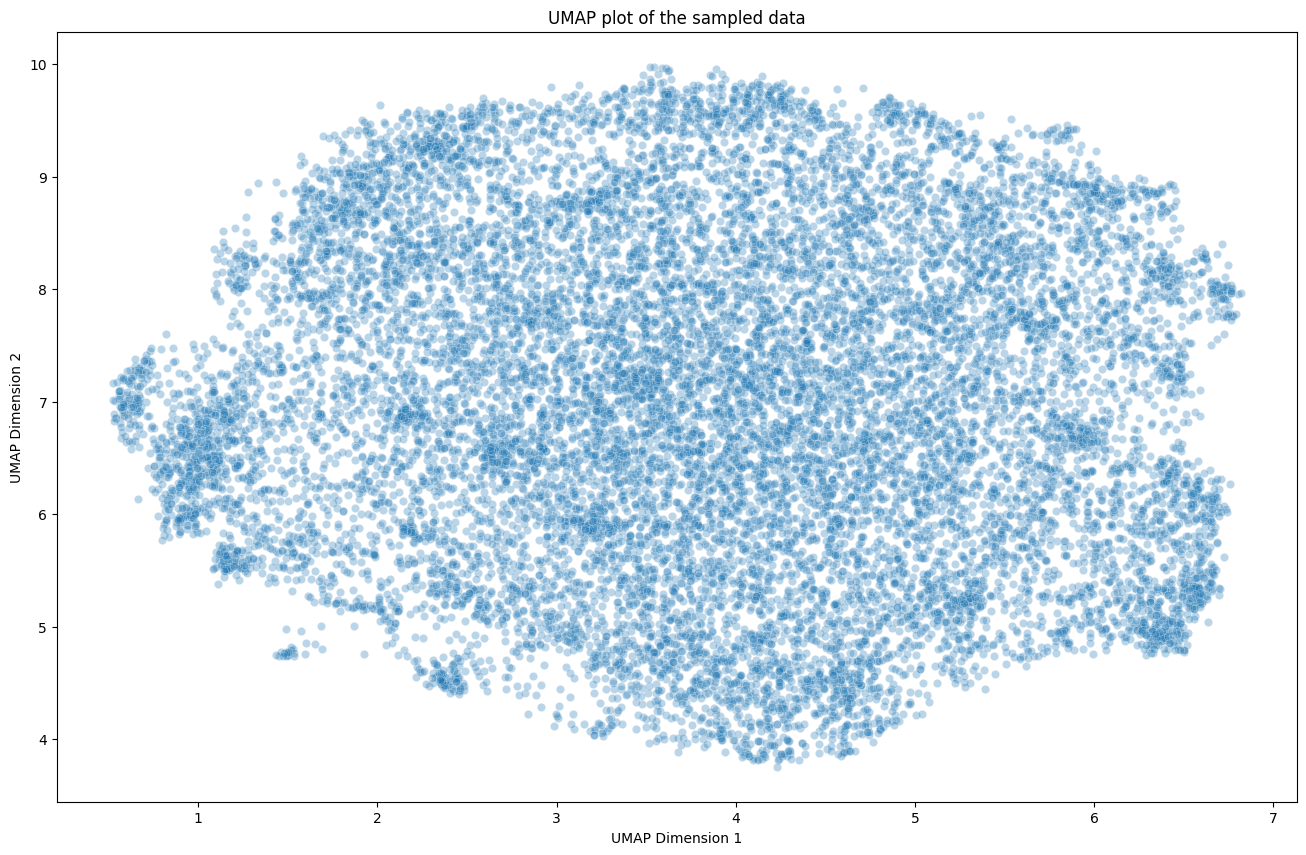

In [10]:
# Re-loading the tensor from the original file path
import torch
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

tensor_path = '../../../pavan/Downloads/W_dec.pt'
data = torch.load(tensor_path)

# Re-assessing the size of the dataset
num_points = data.shape[0]

sample_size = int(num_points)
indices = torch.randperm(num_points)[:sample_size]
data_sample = data[indices]

# Converting the sampled data to numpy array for UMAP
data_sample_np = data_sample.detach().numpy()

# Applying UMAP to the sampled data
umap_sample = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, metric='cosine', verbose=1)
umap_results_sample = umap_sample.fit_transform(data_sample_np)

# Plotting the UMAP results for the sampled data
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=umap_results_sample[:,0], y=umap_results_sample[:,1],
    palette=sns.color_palette("hsv", 10),
    legend="full",
    alpha=0.3
)
plt.title('UMAP plot of the sampled data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


/Users/pavan/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/pavan/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


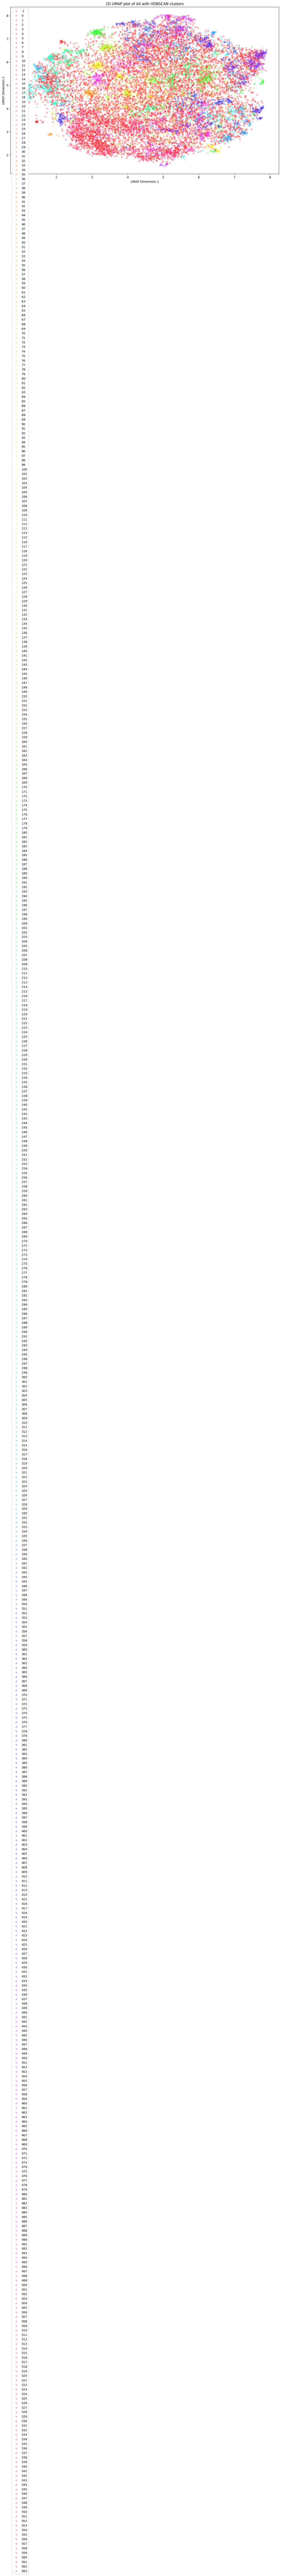

/Users/pavan/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [12]:
import torch
import umap.umap_ as umap
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
tensor_path = '../../../pavan/Downloads/W_dec.pt'
data_A0 = torch.load(tensor_path)

# Assuming data_A0 is already the subset of features you are interested in
# Convert the data to numpy array
data_A0_np = data_A0.detach().numpy()

# First UMAP Embedding (2D for visualization)
umap_embedding_2d = umap.UMAP(n_neighbors=15, n_components=2, metric="cosine", min_dist=0.05, random_state=42).fit_transform(data_A0_np)

# UMAP Embedding for HDBSCAN (10D for clustering)
umap_embedding_hdbscan = umap.UMAP(n_neighbors=15, n_components=10, metric="cosine", min_dist=0.1, random_state=42).fit_transform(data_A0_np)

# Apply HDBSCAN to the 10D UMAP embedding
clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
cluster_labels = clusterer.fit_predict(umap_embedding_hdbscan)

# Plotting the 2D UMAP results with HDBSCAN clusters
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=umap_embedding_2d[:,0], y=umap_embedding_2d[:,1],
    hue=cluster_labels,
    palette=sns.color_palette("hsv", len(np.unique(cluster_labels))),
    legend="full",
    alpha=0.3
)
plt.title('2D UMAP plot of A0 with HDBSCAN clusters')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

# Optionally sort features by one-dimensional UMAP (for analysis, not visualization)
umap_embedding_1d = umap.UMAP(n_neighbors=15, n_components=1, metric="cosine", random_state=42).fit_transform(data_A0_np)
sorted_indices = np.argsort(umap_embedding_1d[:, 0])
sorted_features = data_A0_np[sorted_indices]
